# Predict the Category of a Restaurant based on reviews (Classification Problem)
- all_reviews from yelp_academic_dataset_review.json as the input
- the categories from yelp_academic_dataset_business.json as the output 
- metrics use to evaluate the model - precison, recall, F - 1 score
- confusion matrix 
- FCNN and CNN

## Preparing the Data for Training

In [1]:
%matplotlib inline

import os
import json
import csv

import pandas as pd
import numpy as np

import sklearn.feature_extraction.text as sk_text
from collections.abc import Sequence

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers

In [2]:
# Encode text values to dummy variables
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    df = pd.concat([df, dummies], axis=1)
    df.drop(name, axis=1, inplace=True)

# Convert a pandas df to x, y inputs
def to_xy(df, target):
    features = [x for x in df.columns if x != target]
    
    # Find the type of the target column
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if np.issubdtype(target_type, np.integer):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[features].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[features].values.astype(np.float32), df[target].values.astype(np.float32)

# Plot Confusion Matrix
def plot_confusion_matrix(cm, names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [3]:
# Open the JSON file and create a TSV file
with open('yelp_academic_dataset_review.json', encoding='utf-8') as json_file, open('review.tsv', 'w', encoding='utf-8', newline='') as tsv_file:
    # Create a CSV writer with tab as a delimiter
    csv_writer = csv.writer(tsv_file, delimiter="\t", quoting=csv.QUOTE_MINIMAL)

    # Write the header
    csv_writer.writerow(['business_id', 'text'])

    # Iterate through each line in the JSON file
    for line in json_file:
        # Load JSON data from the line
        data = json.loads(line)

        # Write a row to the TSV file
        csv_writer.writerow([data['business_id'], data['text']])

# Read the TSV file into a Pandas DataFrame
df = pd.read_csv('review.tsv', delimiter='\t', encoding='utf-8')

# Display the DataFrame
df

,business_id,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,"If you decide to eat here, just be aware it is..."
1,7ATYjTIgM3jUlt4UM3IypQ,I've taken a lot of spin classes over the year...
2,YjUWPpI6HXG530lwP-fb2A,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,Cute interior and owner (?) gave us tour of up...
...,...,...
6990275,jals67o91gcrD4DC81Vk6w,Latest addition to services from ICCU is Apple...
6990276,2vLksaMmSEcGbjI5gywpZA,"This spot offers a great, affordable east week..."
6990277,R1khUUxidqfaJmcpmGd4aw,This Home Depot won me over when I needed to g...
6990278,Rr9kKArrMhSLVE9a53q-aA,For when I'm feeling like ignoring my calorie-...


In [4]:
# Combine all reviews of a business into one record

# Read the TSV file into a Pandas DataFrame
df = pd.read_csv('review.tsv', delimiter='\t', encoding='utf-8')

# Combine all reviews of a business into one record
df_review_agg = df.groupby('business_id')['text'].sum()

# Display the aggregated DataFrame
df_review_agg

business_id
---kPU91CF4Lq2-WlRu9Lw    Ate here for the 1st time on Saturday 08/07/20...
--0iUa4sNDFiZFrAdIWhZQ    Very good San Salvadorian place ! Authentic an...
--30_8IhuyMHbSOcNWd6DQ    We stopped going to Action Karate in December ...
--7PUidqRWpRSpXebiyxTg    This place is disgusting, and proof that Edmon...
--7jw19RH9JKXgFohspgQw    This is the best dentist in the area, hands do...
                                                ...                        
zznZqH9CiAznbkV6fXyHWA    Oh my gosh! Yum yum yum! I saw Que Pasta start...
zztOG2cKm87I6Iw_tleZsQ    This course is exactly what I needed to get me...
zzu6_r3DxBJuXcjnOYVdTw    Probably the best Italian food on the Westbank...
zzw66H6hVjXQEt0Js3Mo4A    Went to the Ballwin location this year.  The t...
zzyx5x0Z7xXWWvWnZFuxlQ    Maybe the pizza is good here... but I can real...
Name: text, Length: 150346, dtype: object

In [5]:
# convert into a df format that sklearn accept
df_review = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})

# Display the resulting DataFrame
df_review

,business_id,all_reviews
0,---kPU91CF4Lq2-WlRu9Lw,Ate here for the 1st time on Saturday 08/07/20...
1,--0iUa4sNDFiZFrAdIWhZQ,Very good San Salvadorian place ! Authentic an...
2,--30_8IhuyMHbSOcNWd6DQ,We stopped going to Action Karate in December ...
3,--7PUidqRWpRSpXebiyxTg,"This place is disgusting, and proof that Edmon..."
4,--7jw19RH9JKXgFohspgQw,"This is the best dentist in the area, hands do..."
...,...,...
150341,zznZqH9CiAznbkV6fXyHWA,Oh my gosh! Yum yum yum! I saw Que Pasta start...
150342,zztOG2cKm87I6Iw_tleZsQ,This course is exactly what I needed to get me...
150343,zzu6_r3DxBJuXcjnOYVdTw,Probably the best Italian food on the Westbank...
150344,zzw66H6hVjXQEt0Js3Mo4A,Went to the Ballwin location this year. The t...


In [6]:
# save df_review into a file

df_review.to_csv('df_review.tsv', sep='\t', index=False)

In [7]:
# Create and write header to TSV file
with open('business.tsv', 'w', encoding='utf-8', newline='') as outfile:
    csv_writer = csv.writer(outfile, delimiter="\t", quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(['business_id', 'name', 'city', 'review_count', 'categories'])

    # Open the JSON file and write rows to TSV
    with open('yelp_academic_dataset_business.json', encoding='utf-8') as json_file:
        for line in json_file:
            data = json.loads(line)
            csv_writer.writerow([data['business_id'], data['name'], data['city'], data['review_count'], data['categories']])

# Read the TSV file into a Pandas DataFrame
df_business = pd.read_csv('business.tsv', delimiter='\t', encoding='utf-8')

# Display the DataFrame
df_business

,business_id,name,city,review_count,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,7,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,15,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,22,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,13,"Brewpubs, Breweries, Food"
...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,Edmonton,13,"Nail Salons, Beauty & Spas"
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,Nashville,5,"Pets, Nurseries & Gardening, Pet Stores, Hobby..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,Indianapolis,8,"Shopping, Jewelry, Piercing, Toy Stores, Beaut..."
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,Edwardsville,24,"Fitness/Exercise Equipment, Eyewear & Optician..."


In [8]:
# Filter out the business with less than 20 reviews
df_business = df_business[df_business['review_count'] >= 20]

df_business

,business_id,name,city,review_count,categories
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,22,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,Indianapolis,28,"American (Traditional), Restaurants, Diners, B..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,Largo,100,"Food, Delis, Italian, Bakeries, Restaurants"
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,245,"Sushi Bars, Restaurants, Japanese"
...,...,...,...,...,...
150330,GeEveoOaU2YKD7jJtEfA_g,DeVons Jewelers,Reno,34,"Shopping, Watches, Jewelry"
150331,qQ7FHvkGEMqoPKKXPk4gjA,La Quinta by Wyndham NW Tucson Marana,Tucson,67,"Hotels & Travel, Hotels, Event Planning & Serv..."
150334,LJ4GjQ1HL6kqvIPpNUNNaQ,Shanti Yoga and Ayurveda,Philadelphia,39,"Health & Medical, Yoga, Shopping, Naturopathic..."
150336,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,Philadelphia,35,"Restaurants, Mexican"


In [9]:
# check for nulls
df_business[df_business.isnull().any(axis=1)]

,business_id,name,city,review_count,categories


In [10]:
# Keep only the business in Restaurant category
df_business = df_business[df_business['categories'].str.contains('Restaurants')]
df_business

,business_id,name,city,review_count,categories
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,Indianapolis,28,"American (Traditional), Restaurants, Diners, B..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,Largo,100,"Food, Delis, Italian, Bakeries, Restaurants"
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,245,"Sushi Bars, Restaurants, Japanese"
19,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,205,"Korean, Restaurants"
...,...,...,...,...,...
150319,8n93L-ilMAsvwUatarykSg,Kitchen Gia,Philadelphia,22,"Coffee & Tea, Food, Sandwiches, American (Trad..."
150322,2MAQeAqmD8enCT2ZYqUgIQ,The Melting Pot - Nashville,Nashville,204,"Fondue, Beer, Wine & Spirits, Food, Restaurants"
150323,w_4xUt-1AyY2ZwKtnjW0Xg,Bittercreek Alehouse,Boise,998,"Bars, Gastropubs, Sandwiches, Nightlife, Resta..."
150327,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,Boise,33,"Cafes, Juice Bars & Smoothies, Coffee & Tea, R..."


### Extract only the food culture in categories
- Looking at 'categories', we can see that each record is a combination of multiple categories.
- We want to extract out and only looking at the food cultures of these restaurants

In [11]:
for each in df_business['categories']:
    print(each)

Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries
American (Traditional), Restaurants, Diners, Breakfast & Brunch
Food, Delis, Italian, Bakeries, Restaurants
Sushi Bars, Restaurants, Japanese
Korean, Restaurants
Coffee & Tea, Food, Cafes, Bars, Wine Bars, Restaurants, Nightlife
Steakhouses, Asian Fusion, Restaurants
Restaurants, Italian
Restaurants, Japanese, Seafood
Cocktail Bars, Bars, Italian, Nightlife, Restaurants
Pizza, Restaurants, Salad, Soup
Pizza, Restaurants
Eatertainment, Arts & Entertainment, Brewpubs, American (Traditional), Bakeries, Breweries, Food, Restaurants
Restaurants, Burgers
Restaurants, Specialty Food, Steakhouses, Food, Italian, Pizza, Pasta Shops
Restaurants, Chinese
Coffee & Tea, Restaurants, Wine Bars, Bars, Nightlife, American (Traditional), Event Planning & Services, Food, Caterers, Breakfast & Brunch, Cafes, Diners
Coffee & Tea, Cafes, Pets, Restaurants, Pet Adoption, Food
Restaurants, American (New), Italian
Restaurants, Pizza
Restaurants, Soup, Seaf

In [12]:
# food culture
food_culture_list = [
    'Afghan',
    'African',
    'American',
    'Arabian',
    'Argentine',
    'Armenian',
    'Australian',
    'Austrian',
    'Bangladeshi',
    'Basque',
    'Belgian',
    'Brazilian',
    'British',
    'Bulgarian',
    'Burmese',
    'Cambodian',
    'Caribbean',
    'Dominican',
    'Haitian',
    'Puerto Rican',
    'Trinidadian',
    'Catalan',
    'Chinese',
    'Hainan',
    'Shanghainese',
    'Szechuan',
    'Cuban',
    'Czech',
    'Eritrean',
    'Ethiopian',
    'Filipino',
    'French',
    'Georgian',
    'German',
    'Greek',
    'Guamanian',
    'Hawaiian',
    'Himalayan/Nepalese',
    'Honduran',
    'Hong Kong',
    'Hungarian',
    'Iberian',
    'Indian',
    'Indonesian',
    'Irish',
    'Italian',
    'Calabrian',
    'Sardinian',
    'Sicilian',
    'Tuscan',
    'Japanese',
    'Korean',
    'Laotian',
    'Latin American',
    'Colombian',
    'Salvadoran',
    'Venezuelan',
    'Malaysian',
    'Mediterranean',
    'Mexican',
    'Middle Eastern',
    'Egyptian',
    'Lebanese',
    'European',
    'Mongolian',
    'Moroccan',
    'New Mexican',
    'Nicaraguan',
    'Pakistani',
    'Persian/Iranian',
    'Peruvian',
    'Polish',
    'Polynesian',
    'Portuguese',
    'Russian',
    'Scandinavian',
    'Scottish',
    'Singaporean',
    'Slovakian',
    'Somali',
    'Spanish',
    'Sri Lankan',
    'Syrian',
    'Taiwanese',
    'Thai',
    'Turkish',
    'Ukrainian',
    'Uzbek',
    'Vietnamese'

]

In [13]:
food_culture_list

['Afghan',
 'African',
 'American',
 'Arabian',
 'Argentine',
 'Armenian',
 'Australian',
 'Austrian',
 'Bangladeshi',
 'Basque',
 'Belgian',
 'Brazilian',
 'British',
 'Bulgarian',
 'Burmese',
 'Cambodian',
 'Caribbean',
 'Dominican',
 'Haitian',
 'Puerto Rican',
 'Trinidadian',
 'Catalan',
 'Chinese',
 'Hainan',
 'Shanghainese',
 'Szechuan',
 'Cuban',
 'Czech',
 'Eritrean',
 'Ethiopian',
 'Filipino',
 'French',
 'Georgian',
 'German',
 'Greek',
 'Guamanian',
 'Hawaiian',
 'Himalayan/Nepalese',
 'Honduran',
 'Hong Kong',
 'Hungarian',
 'Iberian',
 'Indian',
 'Indonesian',
 'Irish',
 'Italian',
 'Calabrian',
 'Sardinian',
 'Sicilian',
 'Tuscan',
 'Japanese',
 'Korean',
 'Laotian',
 'Latin American',
 'Colombian',
 'Salvadoran',
 'Venezuelan',
 'Malaysian',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Egyptian',
 'Lebanese',
 'European',
 'Mongolian',
 'Moroccan',
 'New Mexican',
 'Nicaraguan',
 'Pakistani',
 'Persian/Iranian',
 'Peruvian',
 'Polish',
 'Polynesian',
 'Portuguese',

In [14]:
fc = [next((w for w in food_culture_list if w in each), None) for each in df_business['categories']]
fc

[None,
 'American',
 'Italian',
 'Japanese',
 'Korean',
 None,
 None,
 'Italian',
 'Japanese',
 'Italian',
 None,
 None,
 'American',
 None,
 'Italian',
 'Chinese',
 'American',
 None,
 'American',
 None,
 None,
 'American',
 None,
 'American',
 'American',
 'American',
 'American',
 None,
 None,
 None,
 None,
 'American',
 None,
 'Mexican',
 'French',
 'American',
 None,
 'American',
 'Chinese',
 'Italian',
 None,
 None,
 'Japanese',
 'Mexican',
 None,
 None,
 'Italian',
 'American',
 None,
 None,
 None,
 'American',
 'Chinese',
 None,
 None,
 'Japanese',
 'Irish',
 'Italian',
 None,
 None,
 'Italian',
 'American',
 'Chinese',
 None,
 'Irish',
 None,
 None,
 'Caribbean',
 'Japanese',
 'American',
 'Mexican',
 None,
 'Italian',
 'Italian',
 'American',
 'Japanese',
 'Chinese',
 'Chinese',
 None,
 None,
 None,
 'Indian',
 'Greek',
 None,
 None,
 'American',
 'American',
 'Italian',
 'American',
 'Mexican',
 'Mexican',
 None,
 'American',
 'Indian',
 'American',
 'American',
 'Thai',
 'A

In [15]:
# Add in a new column named 'food culture' into business df
df_business['food_culture'] = fc
df_business

C:\Users\rimsa\AppData\Local\Temp\ipykernel_23624\2131176357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business['food_culture'] = fc


,business_id,name,city,review_count,categories,food_culture
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",None
12,il_Ro8jwPlHresjw9EGmBg,Denny's,Indianapolis,28,"American (Traditional), Restaurants, Diners, B...",American
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,Largo,100,"Food, Delis, Italian, Bakeries, Restaurants",Italian
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,245,"Sushi Bars, Restaurants, Japanese",Japanese
19,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,205,"Korean, Restaurants",Korean
...,...,...,...,...,...,...
150319,8n93L-ilMAsvwUatarykSg,Kitchen Gia,Philadelphia,22,"Coffee & Tea, Food, Sandwiches, American (Trad...",American
150322,2MAQeAqmD8enCT2ZYqUgIQ,The Melting Pot - Nashville,Nashville,204,"Fondue, Beer, Wine & Spirits, Food, Restaurants",None
150323,w_4xUt-1AyY2ZwKtnjW0Xg,Bittercreek Alehouse,Boise,998,"Bars, Gastropubs, Sandwiches, Nightlife, Resta...",None
150327,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,Boise,33,"Cafes, Juice Bars & Smoothies, Coffee & Tea, R...",None


In [ ]:
# Display the DataFrame after dropping the column
df_business

,business_id,name,city,review_count,categories,food_culture
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",None
12,il_Ro8jwPlHresjw9EGmBg,Denny's,Indianapolis,28,"American (Traditional), Restaurants, Diners, B...",American
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,Largo,100,"Food, Delis, Italian, Bakeries, Restaurants",Italian
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,245,"Sushi Bars, Restaurants, Japanese",Japanese
19,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,205,"Korean, Restaurants",Korean
...,...,...,...,...,...,...
150319,8n93L-ilMAsvwUatarykSg,Kitchen Gia,Philadelphia,22,"Coffee & Tea, Food, Sandwiches, American (Trad...",American
150322,2MAQeAqmD8enCT2ZYqUgIQ,The Melting Pot - Nashville,Nashville,204,"Fondue, Beer, Wine & Spirits, Food, Restaurants",None
150323,w_4xUt-1AyY2ZwKtnjW0Xg,Bittercreek Alehouse,Boise,998,"Bars, Gastropubs, Sandwiches, Nightlife, Resta...",None
150327,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,Boise,33,"Cafes, Juice Bars & Smoothies, Coffee & Tea, R...",None


In [17]:
# save df to file
df_business.to_csv('df_business.tsv', sep='\t', index=False)

In [18]:
# Merge two dfs along the business_id value
df_merged = pd.merge(df_review, df_business, on='business_id')
df_merged

,business_id,all_reviews,name,city,review_count,categories,food_culture
0,---kPU91CF4Lq2-WlRu9Lw,Ate here for the 1st time on Saturday 08/07/20...,Frankie's Raw Bar,New Port Richey,24,"Seafood, Restaurants, Latin American, Food, Fo...",American
1,--8IbOsAAxjKRoYsBFL-PA,"Took me for 40 bucks through grubhub, no call ...",The Original Italian Pie,Gentilly,27,"Food, Restaurants, Italian",Italian
2,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,Chris's Sandwich Shop,Ardmore,32,"American (Traditional), Restaurants, Pizza, Sa...",American
3,--epgcb7xHGuJ-4PUeSLAw,Love their asiago roll. That and a cup of coff...,Manhattan Bagel,Willow Grove,34,"Restaurants, Food, Bagels, Sandwiches, Breakfa...",None
4,-09Oc2D14vRnmirPh0vlXw,"Had lunch last week, second time I was disappo...",Cracker Barrel Old Country Store,Mount Holly,135,"Diners, Shopping, Caterers, Restaurants, Comfo...",American
...,...,...,...,...,...,...,...
33936,zzHtFjfM7NvuVM1HTsCLGA,I had the smoked salmon ramen special. The bro...,Nom Nom Japanese Kitchen,Paoli,35,"Sushi Bars, Ramen, Restaurants, Japanese",Japanese
33937,zzbZtgPYZS8sTIWQH6DwEw,Last night was my first time over at F&M on Tc...,F & M Patio Bar,New Orleans,86,"Food, American (Traditional), Nightlife, Resta...",American
33938,zzfj1-iPfw0cwnOjY0yUgA,I recently stopped here for lunch.I had debs c...,Ruby's Kitchen,Nashville,24,"Breakfast & Brunch, Burgers, American (Traditi...",American
33939,zzjFdJwXuxBOGe9JeY_EMw,Went in for lunch and tried the jerk chicken a...,Taste of the Islands,Norristown,47,"Caribbean, Restaurants",Caribbean


In [19]:
# drop business_id, review_count, and categories
df_merged.drop(['business_id','review_count','categories'], axis=1, inplace=True)
df_merged

,all_reviews,name,city,food_culture
0,Ate here for the 1st time on Saturday 08/07/20...,Frankie's Raw Bar,New Port Richey,American
1,"Took me for 40 bucks through grubhub, no call ...",The Original Italian Pie,Gentilly,Italian
2,This place is sadly perm closed. I was hoping ...,Chris's Sandwich Shop,Ardmore,American
3,Love their asiago roll. That and a cup of coff...,Manhattan Bagel,Willow Grove,None
4,"Had lunch last week, second time I was disappo...",Cracker Barrel Old Country Store,Mount Holly,American
...,...,...,...,...
33936,I had the smoked salmon ramen special. The bro...,Nom Nom Japanese Kitchen,Paoli,Japanese
33937,Last night was my first time over at F&M on Tc...,F & M Patio Bar,New Orleans,American
33938,I recently stopped here for lunch.I had debs c...,Ruby's Kitchen,Nashville,American
33939,Went in for lunch and tried the jerk chicken a...,Taste of the Islands,Norristown,Caribbean


In [20]:
# save merged_df to a file
df_merged.to_csv('df_merged.tsv', sep='\t', index=False)

In [21]:
# Convert all_reviews column to numpy array
all_reviews_nparray = df_merged['all_reviews'].to_numpy()
all_reviews_nparray

array(['Ate here for the 1st time on Saturday 08/07/2020. \nThe food was ok, had the Lobster Boil . The Lobster was ok for a soft shelled Lobster. The Crabs were soggy and mushy. The Clams were gummy and snotty . The headed shrimp were large and tasty. All the items were precooked, obviously. The fish spread was decent , also had the Fried Shrimp and Shrimp scampi  which were decent. BYOB ... ... The atmosphere was nice except for the zillion Flies. I\'ll be back with a six packAbsolutely fantastic!!!!  I\'ll be back for sure. Fried lobster tail was delicious. Five star for sure.I was sadly disappointed in my experience. We ordered crabs and they were extremely small, watery and over half were bad(sick crabs), we ordered beans and rice which lacked flavor and literally had one bean in it that you can see from the picture. The coleslaw also lacked taste. We ask for grouper nuggets and a few were not cooked all the way. So given the food experience it was nothing like the reviews we read

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using TFIDF Vectorizer to extract input features
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, min_df=250, max_df=10000)
review_word_matrix = vectorizer.fit_transform(all_reviews_nparray)

review_word_matrix

<33941x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 6569879 stored elements in Compressed Sparse Row format>

In [23]:
# Convert it to numpy array
tfidf_data_x = review_word_matrix.toarray()

print(tfidf_data_x)
print()
print('Input type: ', type(tfidf_data_x))
print('Input shape: ', tfidf_data_x.shape)
print()
print(vectorizer.get_feature_names_out())
print()
print('Numbers of distict words: ', len(vectorizer.get_feature_names_out()))

[[0.         0.04870506 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.0634115  0.         ... 0.         0.         0.        ]
 [0.01509879 0.         0.01696421 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Input type:  <class 'numpy.ndarray'>
Input shape:  (33941, 1000)

['17' '1st' '21' '24' '30pm' '3rd' '60' '75' '80' '90' '95' 'accommodate'
 'accompanied' 'act' 'adding' 'adorable' 'adult' 'adults' 'advance'
 'advice' 'ahi' 'aioli' 'airport' 'al' 'alcohol' 'ale' 'alfredo'
 'alligator' 'allow' 'almond' 'amazingly' 'ample' 'anniversary' 'annoyed'
 'annoying' 'answered' 'anyways' 'apologize' 'apology' 'appetite' 'apple'
 'apps' 'areas' 'arrival' 'art' 'artichoke' 'arugula' 'asada' 'asian'
 'asparagus' 'ass' 'assume' 'attempt' 'au' 'ave' 'aware' 'awkwar

In [24]:
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [25]:
# Create output feature (Categories)
# One -hot encoding food culture
y_df = df_merged['food_culture'].to_frame()
encode_text_dummy(y_df, 'food_culture')
print(y_df)
print(type(y_df))
print(y_df.head())

       food_culture-Afghan  food_culture-African  food_culture-American  \
0                        0                     0                      1   
1                        0                     0                      0   
2                        0                     0                      1   
3                        0                     0                      0   
4                        0                     0                      1   
...                    ...                   ...                    ...   
33936                    0                     0                      0   
33937                    0                     0                      1   
33938                    0                     0                      1   
33939                    0                     0                      0   
33940                    0                     0                      0   

       food_culture-Argentine  food_culture-Armenian  food_culture-Australian  \
0                 

In [26]:
# convert output to numpy array
y = y_df.to_numpy()
print('output type: ', type(y))
print('output shape: ',y.shape)
y

output type:  <class 'numpy.ndarray'>
output shape:  (33941, 59)


array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## CNN model
1. Reshape input data to fit into CNN
2. output data should be in one-hot encoding
3. splitting data into train and test
4. difine a CNN model with different kernal sizes, strides
5. Use difeerent combination of activation functions (relu, tanh, sigmoid)
6. loss function --> categorical_crossentropy
7. Adam or sgd as optimizer
8. recall, precision, f1 score and confusion matrix to evaluate the model

In [27]:
x = tfidf_data_x
x.shape

(33941, 1000)

In [28]:
y.shape

(33941, 59)

In [29]:
x_cnn = x.reshape((33941, 1, 1000, 1))
x_cnn.shape

(33941, 1, 1000, 1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x_cnn, y, test_size=0.25, random_state=42)

In [31]:
# load modules
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [32]:
batch_size = 120
epochs = 20

In [33]:
img_rows, img_cols = 1, 1000

In [34]:
# Function to create and compile the CNN model
def create_compile_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(59, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                     activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    model.add(Conv2D(59, kernel_size=(1, 2), strides=(1, 1), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
    model.add(Dropout(0.25))

    model.add(Conv2D(59, kernel_size=(1, 2), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    model.add(Flatten())
    model.add(Dense(1024, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

# Training loop
for i in range(3):
    print(f'Training round {i + 1} -----------------')

    # Define input shape and number of classes
    input_shape = (img_rows, img_cols, 1)
    num_classes = 59

    # Create and compile the CNN model
    cnn = create_compile_model(input_shape, num_classes)

    # Display the model summary
    cnn.summary()

    # Set up callbacks
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath='./best_weights_cnn.hdf5', verbose=0, save_best_only=True)

    # Fitting
    cnn.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=20,
            verbose=2,
            validation_data=(X_test, y_test),
            callbacks=[monitor, checkpointer])

    print('Training finished.....best model')
    print()

    # Load the best weights
    cnn.load_weights('./best_weights_cnn.hdf5')


Training round 1 -----------------



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1000, 59)       118       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 500, 59)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 499, 59)        7021      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 249, 59)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 1, 249, 59)        0         
                                                                 
 conv2d_2 (Conv2D)

c:\Users\rimsa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


213/213 - 20s - loss: 0.8691 - val_loss: 0.5788 - 20s/epoch - 95ms/step
Epoch 3/20
213/213 - 21s - loss: 0.8549 - val_loss: 0.5993 - 21s/epoch - 100ms/step
Epoch 4/20
213/213 - 21s - loss: 0.8390 - val_loss: 0.6124 - 21s/epoch - 99ms/step
Epoch 5/20
213/213 - 21s - loss: 0.8300 - val_loss: 0.6163 - 21s/epoch - 98ms/step
Epoch 6/20
213/213 - 21s - loss: 0.8169 - val_loss: 0.6138 - 21s/epoch - 101ms/step
Epoch 6: early stopping
Training finished.....best model

Training round 2 -----------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1, 1000, 59)       118       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 500, 59)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D

266/266 [==============================] - 2s 7ms/step
Confusion Matrix Plot


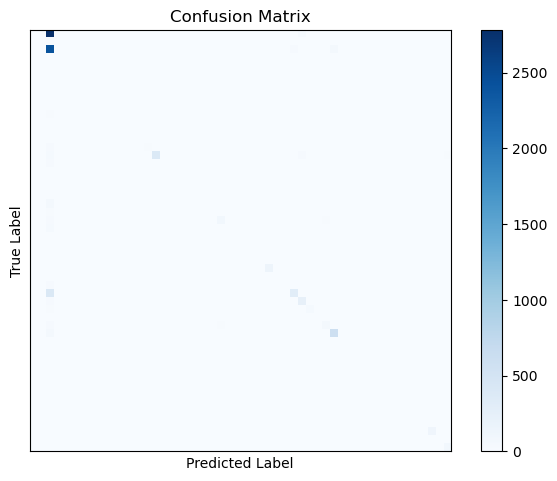

In [35]:
from sklearn.metrics import confusion_matrix
y_true = np.argmax(y_test, axis=1)
pred = cnn.predict(X_test)
pred = np.argmax(pred, axis=1)

cm = confusion_matrix(y_true, pred)
output = []

print('Confusion Matrix Plot')
plt.figure()
plot_confusion_matrix(cm,output)
plt.show()

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_true,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2846
           1       0.00      0.00      0.00        15
           2       0.39      0.95      0.56      2531
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         5
          14       0.67      0.35      0.46        40
          15       0.93      0.80      0.86       481
          16       1.00      0.06      0.12        32
          17       0.00    

c:\Users\rimsa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rimsa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rimsa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
# Function to create and compile the CNN model
def create_compile_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(59, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                     activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    model.add(Conv2D(59, kernel_size=(1, 2), strides=(1, 1), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
    model.add(Dropout(0.25))

    model.add(Conv2D(59, kernel_size=(1, 2), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    # Additional Convolutional Layer
    model.add(Conv2D(59, kernel_size=(1, 2), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
    model.add(Dropout(0.25))

    # Additional Dense Layer
    model.add(Flatten())
    model.add(Dense(1024, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

# Training loop
for i in range(3):
    print(f'Training round {i + 1} -----------------')

    # Define input shape and number of classes
    input_shape = (img_rows, img_cols, 1)
    num_classes = 59

    # Create and compile the CNN model
    cnn = create_compile_model(input_shape, num_classes)

    # Display the model summary
    cnn.summary()

    # Set up callbacks
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath='./best_weights_cnn.hdf5', verbose=0, save_best_only=True)

    # Fitting
    cnn.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=20,
            verbose=2,
            validation_data=(X_test, y_test),
            callbacks=[monitor, checkpointer])

    print('Training finished.....best model')
    print()

    # Load the best weights
    cnn.load_weights('./best_weights_cnn.hdf5')


Training round 1 -----------------
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 1, 1000, 59)       118       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 1, 500, 59)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 1, 499, 59)        7021      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 1, 249, 59)        0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 1, 249, 59)        0         
                                                                 
 conv2d_28 (Conv2D

266/266 [==============================] - 2s 6ms/step
Confusion Matrix Plot


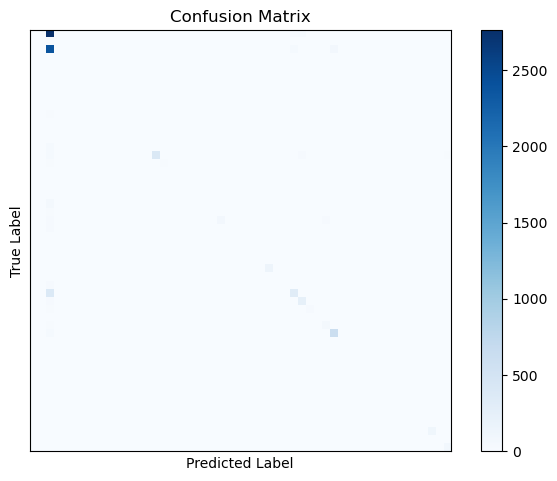

In [78]:
from sklearn.metrics import confusion_matrix
y_true = np.argmax(y_test, axis=1)
pred = cnn.predict(X_test)
pred = np.argmax(pred, axis=1)

cm = confusion_matrix(y_true, pred)
output = []

print('Confusion Matrix Plot')
plt.figure()
plot_confusion_matrix(cm,output)
plt.show()

In [79]:
from sklearn.metrics import classification_report

print(classification_report(y_true,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2846
           1       0.00      0.00      0.00        15
           2       0.40      0.94      0.56      2531
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00        40
          15       0.92      0.83      0.87       481
          16       0.71      0.62      0.67        32
          17       0.00    

c:\Users\rimsa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rimsa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rimsa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
